# Investigating Assumptions of the Likelihood

This notebook is intended to logically be before other notebooks that contribute to the paper. It investigates some of the assumptions of the likelihood, and makes sure the data to conforms to those assumptions.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import glob

import notebook_utils as utl
import alan_data_utils as utils
from statsmodels.tsa.stattools import adfuller
from scipy.stats import anderson
from astropy import units as u
from edges_cal.spectra import read_spectrum
from edges_cal.tools import bin_array

In [2]:
utl.setup_mpl()

In [3]:
utl.print_versions()

Numpy Version:  1.21.2
Astropy Version:  5.0
read_acq Version:  0.4.6.dev34+gfe03c54
edges-io Version:  4.1.2.dev2+g80276ea
edges-cal Version:  6.1.0.post0.dev7+gdfef8b6
edges-analysis Version:  4.1.1.post0.dev5+ga4e388a


In [9]:
spec = {fl.split("spectra_")[-1].split(".")[0]: np.load(fl, allow_pickle=True) for fl in glob.glob("outputs/raw/new_calobs_full_spectra_*.npz")}

## 1. Is the Data Stationary?

We assume that the data is Gaussian and that we can use a noise model based on empirically obtaining the standard deviation of the data. Here we play with that assumption a bit to make sure it's a good one.

In [1]:
# spec = {name: load.spectrum.get_spectra() for name, load in utils.calobs._loads.items()}
# for name, sp in spec.items():
#     np.savez(f'calobs_full_spectra_{name}.npz', **sp)

In [5]:
adfuller_metrics = {name: [adfuller(q) for q in spec[name]['Q'][::500]] for name in spec}

In [12]:
print("Maximum p-values for determining stationarity (over frequency):")
for name, m in adfuller_metrics.items():
    print(f"{name:>12}: {np.max([mm[1] for mm in m]):.1e}")

Maximum p-values for determining stationarity (over frequency):
    hot_load: 2.5e-30
       short: 0.0e+00
     ambient: 6.3e-28
        open: 8.4e-28


So, the distributions are highly stationary!

## 2. Is the Data Gaussian?

In [6]:
anderson_metrics = {name: [anderson(q) for q in spec[name]['Q']] for name in spec}

Text(0.5, 0, 'Frequency [MHz]')

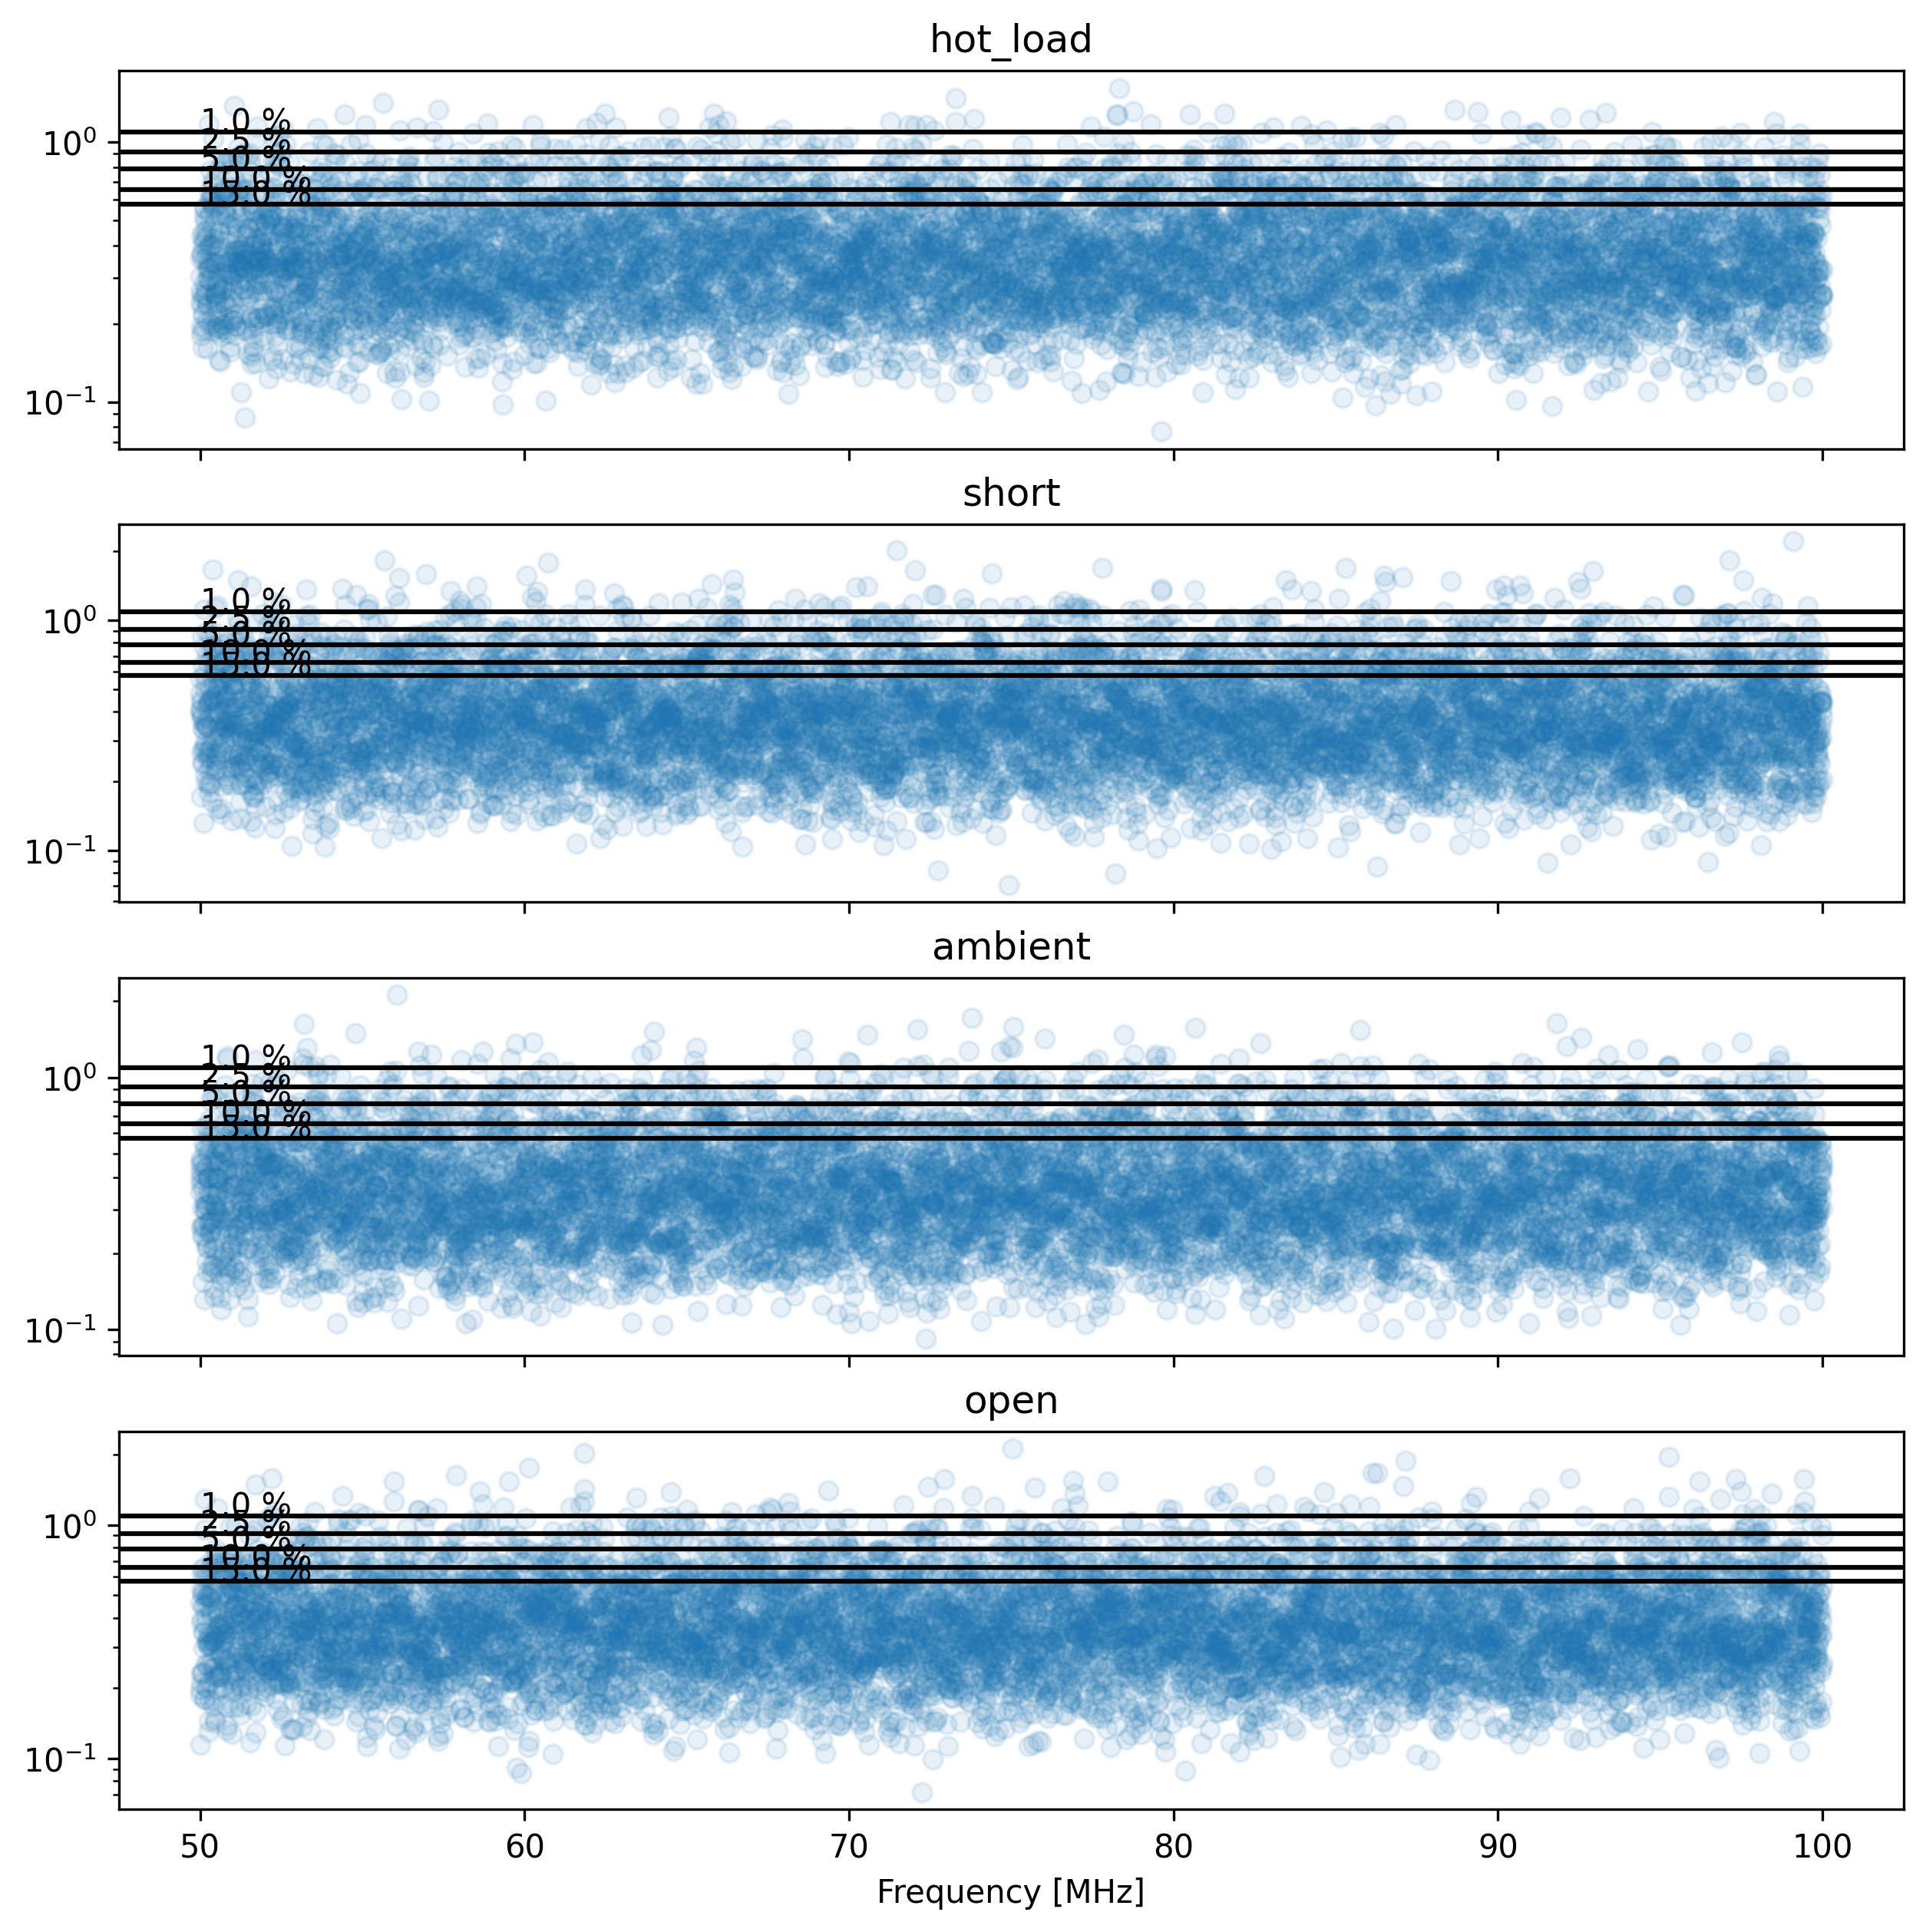

In [7]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

for i, (name, andy) in enumerate(anderson_metrics.items()):
    ax[i].scatter(np.linspace(50, 100, 8193), [a.statistic for a in andy], alpha=0.1)
    for cval, sig in zip(andy[0].critical_values, andy[0].significance_level):
        ax[i].axhline(cval, color='k')
        ax[i].text(50, cval, f'{sig} %')
    ax[i].set_title(name)
    ax[i].set_yscale('log')
    
ax[-1].set_xlabel("Frequency [MHz]")

In [8]:
for i, (name, andy) in enumerate(anderson_metrics.items()):
    n = len([a.statistic for a in andy if a.statistic > a.critical_values[-1]])
    print(name, n/8193)

hot_load 0.006468936897351398
short 0.01415842792627853
ambient 0.009154155986818015
open 0.011595264249969485


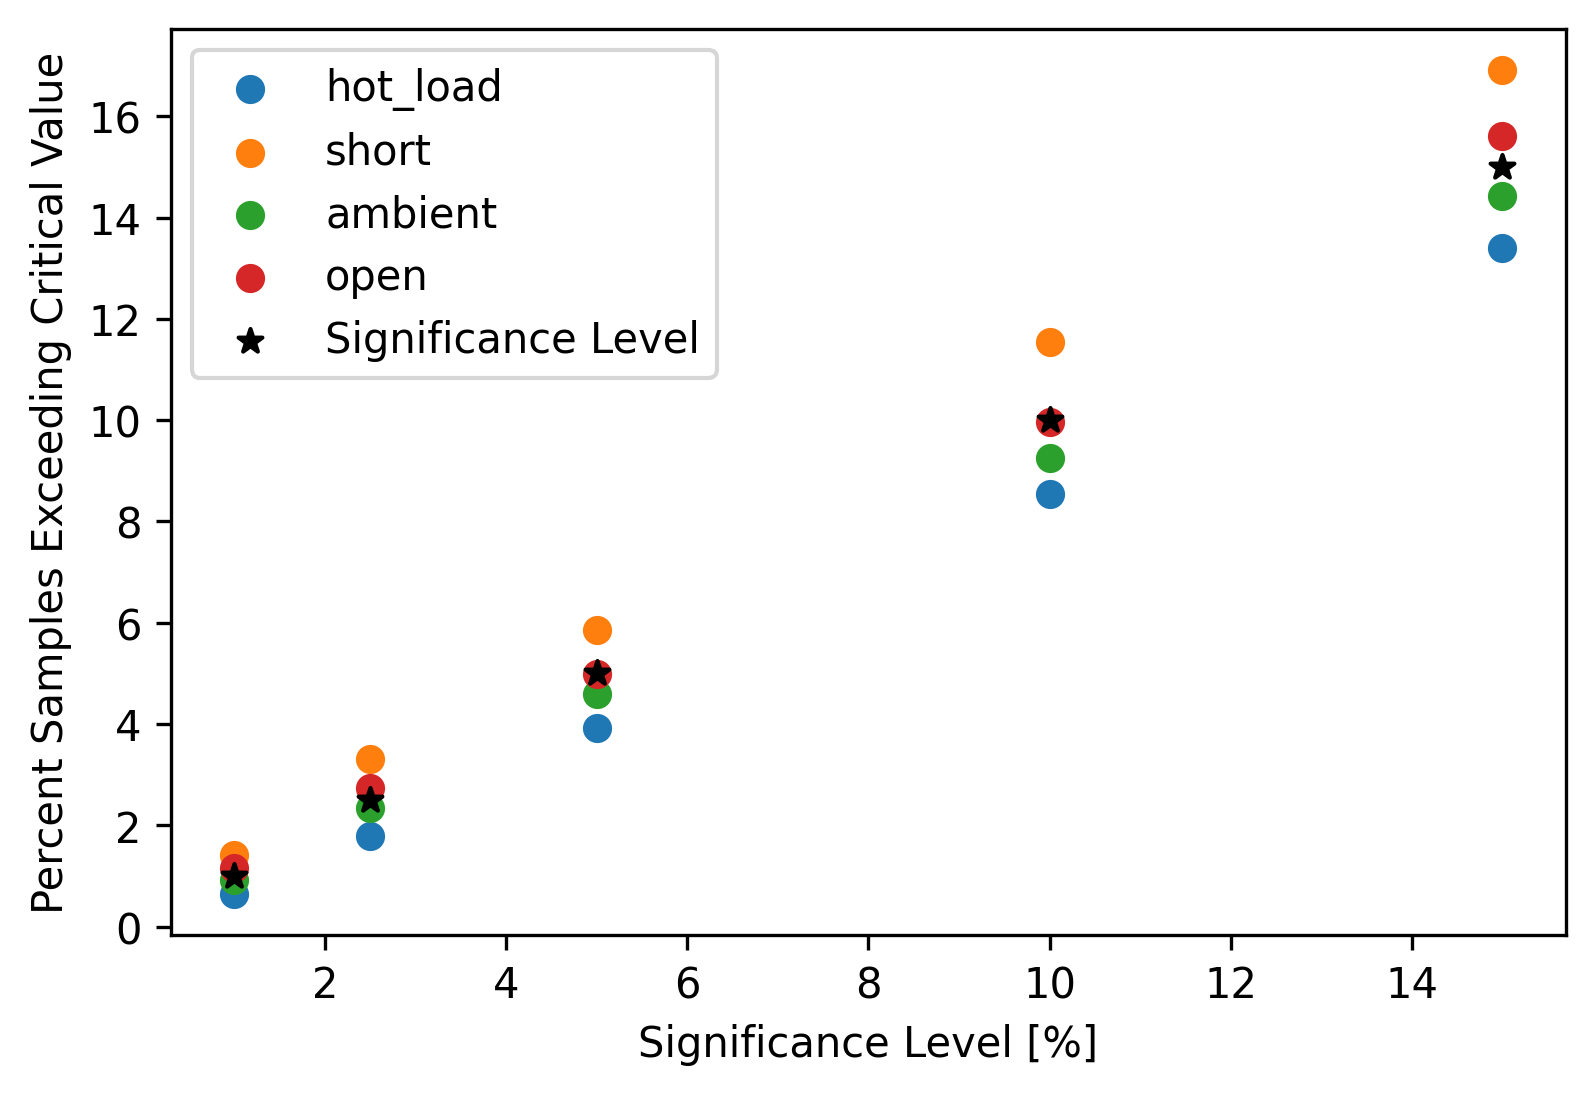

In [29]:
for i, (name, andy) in enumerate(anderson_metrics.items()):
    
    for j, c in enumerate(andy[0].critical_values):
        n = len([a.statistic for a in andy if a.statistic > c])
        plt.scatter(andy[0].significance_level[j], [100*n/8193], c=f'C{i}', label=name if not j else None)
    
a = anderson_metrics['hot_load'][0]
plt.scatter(a.significance_level, a.significance_level, c='k', label='Significance Level', marker='*')
    
plt.xlabel("Significance Level [%]")
plt.ylabel("Percent Samples Exceeding Critical Value")
plt.legend()
plt.savefig("gaussianity_test.pdf")

The interpretation of the statistic is, I think, that if a blue point is above the 1.0% line, then we have a 1% chance of being wrong in rejecting the null hypothesis (that it's a normal distribution). I.e. the higher it is the less likely it is to be Gaussian.

I believe what this means is that, while for each source, there are some frequencies for which the test seems to be quite OK to reject Gaussianity, the number of those frequencies themselves is below 1%. That is, we are entirely unsurprised that we should obtain <1% of samples that reject normality at the 1% level! This is a strong indication of Gaussianity.

## 3. Are Frequencies Independent?

Here, instead of doing the analysis proper, we point to memo 196: http://loco.lab.asu.edu/loco-memos/edges_reports/EDGES_Memo_196_v0.pdf. The result is that we need to bin about 16 bins of frequency for the noise model to be accurate to ~1%.